In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, precision_recall_curve, f1_score,
                           accuracy_score, recall_score, precision_score, RocCurveDisplay)
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

# 데이터 로드
X_train = pd.read_csv("../data/X_train_improved.csv")
X_val = pd.read_csv("../data/X_val_improved.csv")
X_test = pd.read_csv("../data/X_test_improved.csv")
y_train = pd.read_csv("../data/y_train_improved.csv").values.ravel()
y_val = pd.read_csv("../data/y_val_improved.csv").values.ravel()
y_test = pd.read_csv("../data/y_test_improved.csv").values.ravel()

print("="*50)
print("데이터 로드 완료")
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print("="*50)

# 클래스 가중치 계산
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))
print(f"클래스 가중치: {class_weight_dict}")

데이터 로드 완료
Train: (7907, 13), Val: (1576, 13), Test: (1969, 13)
클래스 가중치: {np.int64(0): np.float64(0.6499260233437448), np.int64(1): np.float64(2.167489035087719)}


In [2]:
# 모델 정의 및 학습
def train_and_evaluate_model(name, model, X_train, y_train, X_val, y_val):
    print(f"\n{'='*20} {name} {'='*20}")
    
    # 학습
    model.fit(X_train, y_train)
    
    # 예측 (확률)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    # 최적 임계값 찾기 (F1 score 기준)
    best_threshold = 0.5
    best_f1_temp = 0
    for threshold in np.arange(0.1, 0.9, 0.05):
        y_pred_temp = (y_pred_proba >= threshold).astype(int)
        f1_temp = f1_score(y_val, y_pred_temp)
        if f1_temp > best_f1_temp:
            best_f1_temp = f1_temp
            best_threshold = threshold
    
    # 최적 임계값으로 예측
    y_pred = (y_pred_proba >= best_threshold).astype(int)
    
    # 평가 지표 계산
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    
    # 결과 출력
    print(f"최적 임계값: {best_threshold:.2f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("\n혼동 행렬:")
    print(confusion_matrix(y_val, y_pred))
    
    return {
        'model': model,
        'threshold': best_threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

# 여러 모델 정의
models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2,
        class_weight=class_weight_dict, random_state=42, n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100, max_depth=6, learning_rate=0.1, 
        scale_pos_weight=class_weights[1]/class_weights[0],
        random_state=42, use_label_encoder=False, eval_metric='logloss'
    ),
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42
    ),
    'LogisticRegression': LogisticRegression(
        class_weight=class_weight_dict, max_iter=1000, random_state=42
    )
}

In [3]:
# 모델 학습 및 최고 모델 선정
results = {}
best_model_name = None
best_f1 = 0

for name, model in models.items():
    results[name] = train_and_evaluate_model(name, model, X_train, y_train, X_val, y_val)
    if results[name]['f1'] > best_f1:
        best_f1 = results[name]['f1']
        best_model_name = name

print("\n" + "="*50)
print(f"최고 성능 모델: {best_model_name}")
print(f"F1-Score: {results[best_model_name]['f1']:.4f}")
print("="*50)


==================== RandomForest ====================
최적 임계값: 0.70
Accuracy: 0.9860
Precision: 0.8636
Recall: 0.7037
F1-Score: 0.7755
ROC-AUC: 0.9711

혼동 행렬:
[[1516    6]
 [  16   38]]

==================== XGBoost ====================
최적 임계값: 0.85
Accuracy: 0.9879
Precision: 0.8723
Recall: 0.7593
F1-Score: 0.8119
ROC-AUC: 0.9673

혼동 행렬:
[[1516    6]
 [  13   41]]

==================== GradientBoosting ====================
최적 임계값: 0.70
Accuracy: 0.9886
Precision: 0.8600
Recall: 0.7963
F1-Score: 0.8269
ROC-AUC: 0.9709

혼동 행렬:
[[1515    7]
 [  11   43]]

==================== LogisticRegression ====================
최적 임계값: 0.85
Accuracy: 0.9657
Precision: 0.5000
Recall: 0.5926
F1-Score: 0.5424
ROC-AUC: 0.9404

혼동 행렬:
[[1490   32]
 [  22   32]]

최고 성능 모델: GradientBoosting
F1-Score: 0.8269


In [4]:
# 최고 모델 (GradientBoosting) 테스트 데이터 평가
print("\n테스트 데이터 평가:")
best_model_obj = results[best_model_name]['model']
best_threshold = results[best_model_name]['threshold']

y_test_proba = best_model_obj.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= best_threshold).astype(int)

print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Test Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"Test F1-Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
print("\n테스트 혼동 행렬:")
print(confusion_matrix(y_test, y_test_pred))

# 모델 및 임계값 저장
joblib.dump(best_model_obj, f'../models/best_model_{best_model_name}.pkl')
joblib.dump(best_threshold, '../models/best_threshold.pkl')

print(f"\n모델 저장 완료: best_model_{best_model_name}.pkl")
print(f"임계값 저장 완료: best_threshold.pkl (값: {best_threshold:.3f})")


테스트 데이터 평가:
Test Accuracy: 0.9914
Test Precision: 0.9180
Test Recall: 0.8235
Test F1-Score: 0.8682
Test ROC-AUC: 0.9854

테스트 혼동 행렬:
[[1896    5]
 [  12   56]]

모델 저장 완료: best_model_GradientBoosting.pkl
임계값 저장 완료: best_threshold.pkl (값: 0.700)



상위 10개 중요 특징:
                   feature  importance
2         Rotational speed    0.340488
4                Tool wear    0.231208
3                   Torque    0.146966
6             Power_factor    0.121118
5                Temp_diff    0.116352
8                   Type_L    0.016830
1      Process temperature    0.009916
0          Air temperature    0.008654
9                   Type_M    0.005777
10  Tool_wear_category_Low    0.001408


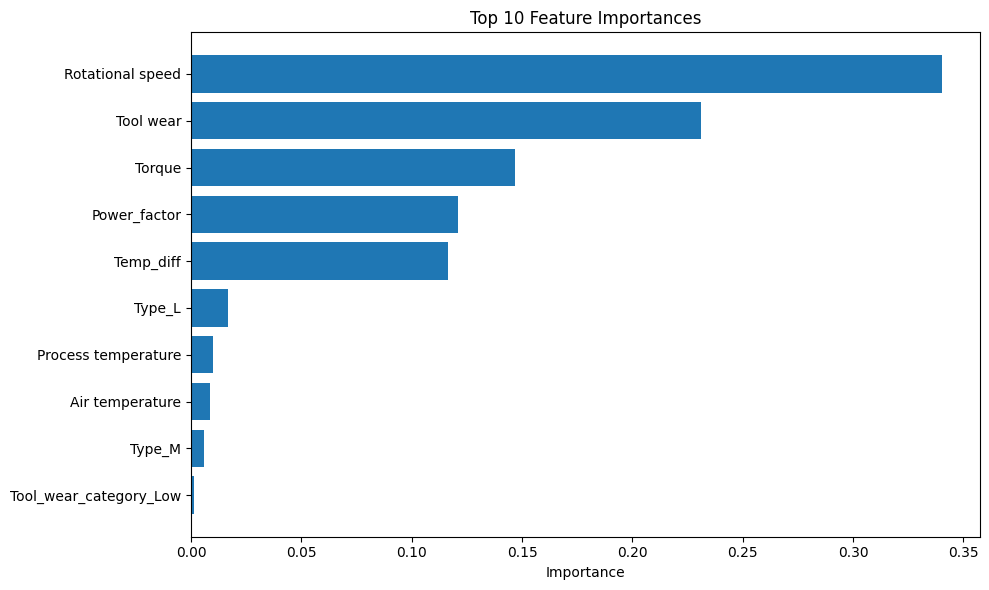

<Figure size 600x600 with 0 Axes>

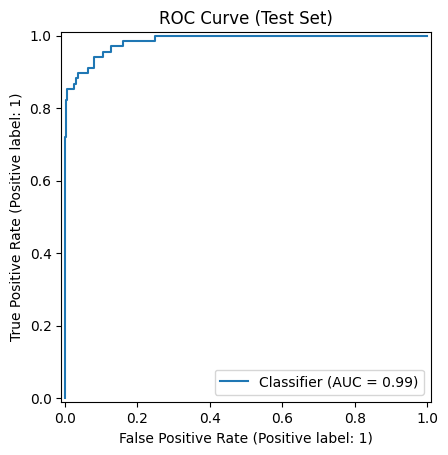

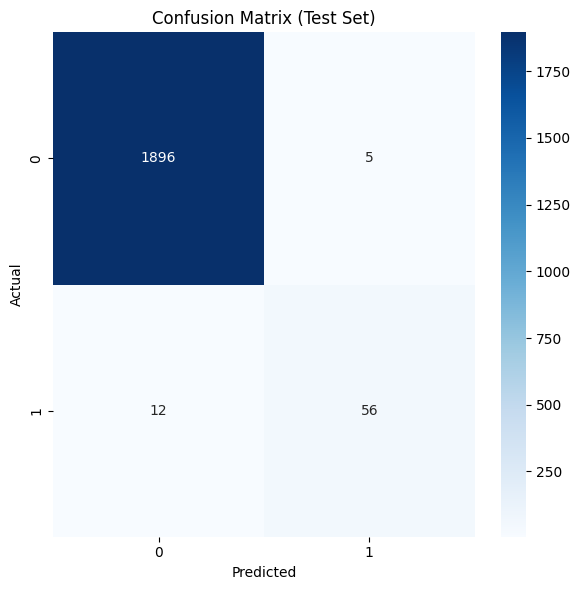

In [ ]:
# 최고 모델(GradientBoosting)시각화
if hasattr(best_model_obj, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model_obj.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n상위 10개 중요 특징:")
    print(feature_importance.head(10))
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance.head(10)['feature'], 
             feature_importance.head(10)['importance'])
    plt.xlabel('Importance')
    plt.title('Top 10 Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('../models/feature_importance.png')
    plt.show()

## ROC 곡선 시각화
plt.figure(figsize=(6,6))
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve (Test Set)")
plt.savefig('../models/roc_curve.png')
plt.show()

## 혼동 행렬 시각화
plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.savefig('../models/confusion_matrix.png')
plt.show()